# Disentangle simulated colinear covariates


## Imports


In [1]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import anndata
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import minmax_scale
from matplotlib_venn import venn2, venn2_circles
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score
from scipy.stats import pearsonr, spearmanr
from pysankey2 import Sankey
from scipy import sparse
import DeepDive
import torch
import glob
import os

In [2]:
import sys
sys.path.insert(0, "../utils")

In [3]:
from simulation import simulate_scATAC_seq_data, simulate_scATAC_seq_data_continuous, generate_dependency_matrix, simulate_scATAC_seq_data_missing, get_DE, get_model_DE, cramers_v, find_recall
from utils import get_colormap_colors

## Simulate a single dataset with known entanglement

In [4]:
n_cells = 1000
n_features = 500
covariates = {
    "Uppercase": ["A", "B"],
    "Lowercase": ["a", "b"],
}
dependency_matrix = generate_dependency_matrix(2,2,0.5)
simulation_result = simulate_scATAC_seq_data(
    n_cells, 
    n_features, 
    covariates=covariates,
    max_effect_sizes=[0.7, 0.7],
    sample_feature_p=[0.10, 0.10],
    dependency=dependency_matrix
)
fragment_counts = simulation_result["data"]
covariate_assignments = simulation_result["covariate_assignments"]
pivot = simulation_result["pivot"]
effect_sizes = simulation_result["effect_sizes"]


In [5]:
adata = anndata.AnnData(fragment_counts)

In [6]:
adata.obs = covariate_assignments

In [7]:
sc.pp.log1p(adata)

In [8]:
sc.tl.pca(adata, svd_solver="arpack")

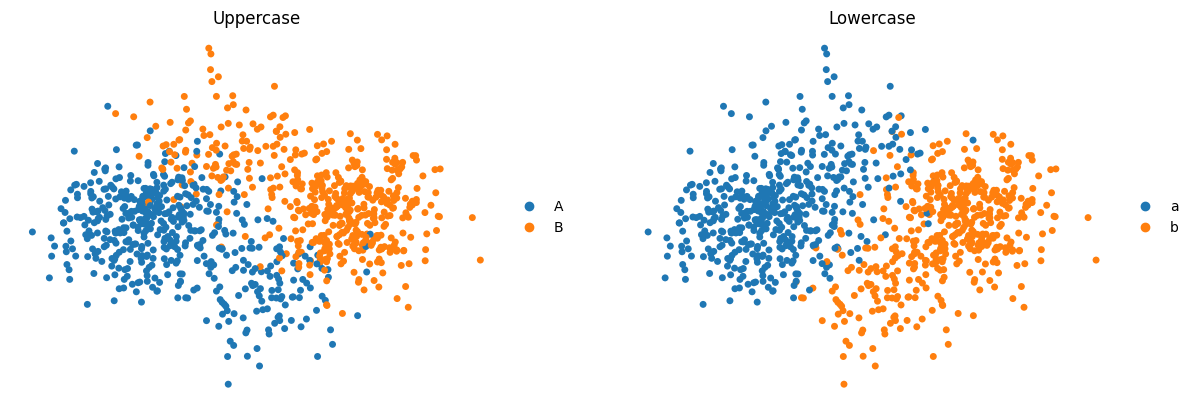

In [9]:
fig = sc.pl.pca(adata, color=['Uppercase', 'Lowercase'], s = 100, return_fig = True, frameon = False)
fig.savefig('../figures/S3B.pdf', transparent=True)

## Compare true and observed effect sizes

In [10]:
n_cells = 1000
n_features = 5000
covariates = {
    "Uppercase": ["A", "B"],
    "Lowercase": ["a", "b"],
}
steps = np.arange(0.0, 1.05, 0.1)
n_colors = len(steps)
colors = get_colormap_colors('RdBu', n_colors)

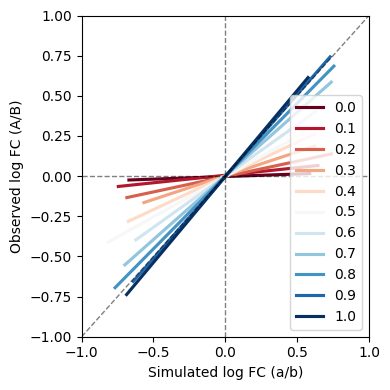

In [11]:
fig, ax = plt.subplots(1,1, figsize = (4,4))
for idx, i in enumerate(steps):
    dependency_matrix = generate_dependency_matrix(2,2,i)

    simulation_result = simulate_scATAC_seq_data(
        n_cells, 
        n_features, 
        covariates=covariates,
        max_effect_sizes=[0.4, 0.4],
        sample_feature_p=[0.10, 0.10],
        dependency=dependency_matrix
    )
    fragment_counts = simulation_result["data"]
    covariate_assignments = simulation_result["covariate_assignments"]
    pivot = simulation_result["pivot"]
    effect_sizes = simulation_result["effect_sizes"]
    contingency = pd.crosstab(covariate_assignments['Uppercase'], covariate_assignments['Lowercase']).values
    cramer_v = cramers_v(contingency)
    
    adata = anndata.AnnData(fragment_counts)
    adata.obs = covariate_assignments
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    
    ef_up = pd.DataFrame(effect_sizes['Uppercase']).sort_values('A')
    ef_low = pd.DataFrame(effect_sizes['Lowercase']).sort_values('a')
    ef_up.index = adata.var.index[ef_up.index]
    ef_low.index = adata.var.index[ef_low.index]
    sc.tl.rank_genes_groups(adata, "Uppercase", method="wilcoxon")
    result = adata.uns["rank_genes_groups"]
    groups = result["names"].dtype.names
    df = pd.DataFrame(
        {
            f"{group}_{key[:1]}": result[key][group]
            for group in groups
            for key in ["names", "logfoldchanges"]
        }

    )
    observed_A=df[['A_n', 'A_l']].set_index('A_n')
    observed_B=df[['B_n', 'B_l']].set_index('B_n')
    observed = pd.concat([observed_A, observed_B], axis = 1)

    affected = (np.log2(ef_low['a'] / ef_low['b']) != 0) & (np.log2(ef_up['A'] / ef_up['B']) == 0)

    sns.regplot(x = np.log2(ef_low['a'] / ef_low['b'])[affected],
                y = observed.A_l[ef_low['a'].index][affected],
                scatter=False,
                color = colors[idx], 
                label = round(cramer_v, 1), 
                ci = None, 
                ax = ax
               )
    
ax.legend(title='Entanglement',bbox_to_anchor=(1.04, 1), loc="upper left")
ax.set_xlabel('Simulated log FC (a/b)')
ax.set_ylabel('Observed log FC (A/B)')
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
X_plot = np.linspace(-1, 1)
Y_plot = X_plot
sns.lineplot(x=X_plot, y=Y_plot, color = 'k', linestyle='--', linewidth=1, ax = ax, alpha = 0.5)
ax.axhline(0.0, color='k', linestyle='--', linewidth=1, alpha = 0.5) 
ax.axvline(0.0, color='k', linestyle='--', linewidth=1, alpha = 0.5) 
plt.tight_layout()
fig.savefig('../figures/F1C.pdf', transparent=True)

## Fit DeepDive and disentangle

In [12]:
n_decoders = 20 
model_params = {
    'n_epochs_pretrain_ae' : 200*n_decoders,
    'n_decoders' : n_decoders,
}

train_params = {
    'max_epoch' : 300*n_decoders, 
    'batch_size' : 512, 
}
discrete_covriate_keys = ['Uppercase', 'Lowercase']

In [13]:
n_cells = 5000
n_features = 5000
covariates = {
    "Uppercase": ["A", "B"],
    "Lowercase": ["a", "b"],
}
dependency_matrix = generate_dependency_matrix(2,2,0.5)
simulation_result = simulate_scATAC_seq_data(
    n_cells, 
    n_features, 
    covariates=covariates,
    max_effect_sizes=[0.7, 0.7],
    sample_feature_p=[0.10, 0.10],
    dependency=dependency_matrix
)
fragment_counts = simulation_result["data"]
covariate_assignments = simulation_result["covariate_assignments"]
pivot = simulation_result["pivot"]
effect_sizes = simulation_result["effect_sizes"]


In [14]:
adata = anndata.AnnData(fragment_counts)
adata.X = sparse.csr_matrix(adata.X) 
adata.obs = covariate_assignments
adata.obs[discrete_covriate_keys] = adata.obs[discrete_covriate_keys].astype(str)

In [15]:
adata.write_h5ad('../data/Simulated_single/Simulated_single_for_rep.h5ad')


In [16]:
model = DeepDive.DeepDive(adata = adata, 
                        discrete_covariate_names = discrete_covriate_keys,
                        **model_params
                       )


In [17]:
model_path = f'../models/F1_simulated_single/deepdive_model_for_rep.pt'


In [18]:
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
else:
    
    model.train_model(adata, None, 
                  **train_params)
    torch.save(model.state_dict(), model_path)


Epoch Train [6000 / 6000]: 100%|██████████| 10/10 [00:00<00:00, 47.47it/s, ETA=01d:00h:15:m12s|01d:00h:15:m12s, kl_loss=6.95, recon_loss=6.99e+3]


In [19]:
sc.pp.log1p(adata)


In [20]:
ef_up = pd.DataFrame(effect_sizes['Uppercase']).sort_values('A')
ef_low = pd.DataFrame(effect_sizes['Lowercase']).sort_values('a')
ef_up.index = adata.var.index[ef_up.index]
ef_low.index = adata.var.index[ef_low.index]

In [21]:
sc.tl.rank_genes_groups(adata, "Uppercase", method="wilcoxon")
result = adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names
df = pd.DataFrame(
    {
        f"{group}_{key[:1]}": result[key][group]
        for group in groups
        for key in ["names", "logfoldchanges", 'pvals_adj']
    }
)
observed_A=df[['A_n', 'A_l', 'A_p']].set_index('A_n')
observed_B=df[['B_n', 'B_l', 'B_p']].set_index('B_n')

sc.tl.rank_genes_groups(adata, "Lowercase", method="wilcoxon")
result = adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names
df = pd.DataFrame(
    {
        f"{group}_{key[:1]}": result[key][group]
        for group in groups
        for key in ["names", "logfoldchanges", 'pvals_adj']
    }
)
observed_a=df[['a_n', 'a_l', 'a_p']].set_index('a_n')
observed_b=df[['b_n', 'b_l', 'b_p']].set_index('b_n')

In [22]:
observed = pd.concat([observed_A, observed_B, observed_a, observed_b], axis = 1)
observed['order'] = [int(x.split('_')[1]) for x in observed.index]
observed = observed.sort_values('order')

In [23]:
observed['Eff_up'] = np.log2(effect_sizes['Uppercase']['A'] / effect_sizes['Uppercase']['B'])
observed['Eff_low'] = np.log2(effect_sizes['Lowercase']['a'] / effect_sizes['Lowercase']['b'])

In [24]:
ab_not_AB = (np.log2(effect_sizes['Lowercase']['a'] / effect_sizes['Lowercase']['b']) != 0) & (np.log2(effect_sizes['Uppercase']['A'] / effect_sizes['Uppercase']['B']) == 0)
AB_not_ab = (np.log2(effect_sizes['Lowercase']['a'] / effect_sizes['Lowercase']['b']) == 0) & (np.log2(effect_sizes['Uppercase']['A'] / effect_sizes['Uppercase']['B']) != 0)
both = (np.log2(effect_sizes['Lowercase']['a'] / effect_sizes['Lowercase']['b']) != 0) & (np.log2(effect_sizes['Uppercase']['A'] / effect_sizes['Uppercase']['B']) != 0)
none = (np.log2(effect_sizes['Lowercase']['a'] / effect_sizes['Lowercase']['b']) == 0) & (np.log2(effect_sizes['Uppercase']['A'] / effect_sizes['Uppercase']['B']) == 0)

In [25]:
DE = DeepDive.compare_groups(model, adata=adata, groupA="A", groupB="B", covariate="Uppercase", fdr_method="fdr_bh")
observed['Difference'] = DE['Difference'].values
observed['Zscore'] = DE['Zscore'].values
observed['FDR'] = DE['FDR'].values
observed['Pvalue'] = DE['Pvalue'].values
DE_low = DeepDive.compare_groups(model, adata=adata, groupA="a", groupB="b", covariate="Lowercase", fdr_method="fdr_bh")
observed['Difference_low'] = DE_low['Difference'].values
observed['Zscore_low'] = DE_low['Zscore'].values
observed['FDR_low'] = DE_low['FDR'].values
observed['Pvalue_low'] = DE_low['Pvalue'].values

In [26]:
def return_sets(g1, g2):
    if g1 == 'Eff_up' or g1 == 'Eff_low':
        s_g1 = set(observed[observed[g1] != 0].index)
        s_g2 = set(observed[observed[g2] != 0].index)
    else:
        s_g1 = set(observed[observed[g1] < 0.05].index)
        s_g2 = set(observed[observed[g2] < 0.05].index)
    return [s_g1, s_g2]

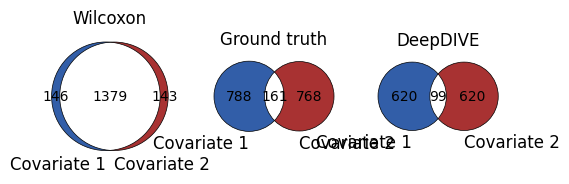

In [27]:
gs = [['A_p', 'a_p'],
      ['Eff_up', 'Eff_low'],
      ['Pvalue', 'Pvalue_low']]
names = ['Wilcoxon', 'Ground truth', 'DeepDIVE']

fig, ax = plt.subplots(1,3, figsize=(6, 2))
for i in range(3):
    vd = venn2(return_sets(*gs[i]), ax = ax[i],set_labels = ['Covariate 1', 'Covariate 2'],  set_colors = ['#325ea8', '#a83232'],alpha = 1 )
    venn2_circles(return_sets(*gs[i]), ax = ax[i], linewidth=0.5) 
    vd.get_patch_by_id('11').set(visible=False, label=None)
    ax[i].set_title(names[i])

plt.savefig('../figures/S3C.pdf', transparent = True)

In [28]:
def mapper(c1, c2):
    if c1>c2: return 0
    if c2>c1: return 1
    if sum([c1, c2]) > 1: return 2
    else: return 3

In [29]:
id_to_str = {0:'a_A/B',
             1:'c_a/b',
             2:'b_Shared',
             3:'d_Unaffected',}
observed['true_group'] = np.stack([AB_not_ab, ab_not_AB, both, none]).argmax(axis = 0)
observed['true_group'] = observed['true_group'].map(id_to_str)

observed['observed_group'] = [mapper(c1, c2) for c1, c2 in zip(observed['A_p'] < 0.05, observed['a_p'] < 0.05)]
observed['observed_group'] = observed['observed_group'].map(id_to_str)
observed['model_group'] = [mapper(c1, c2) for c1, c2 in zip(observed['Pvalue'] < 0.05, observed['Pvalue_low'] < 0.05)]
observed['model_group'] = observed['model_group'].map(id_to_str)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

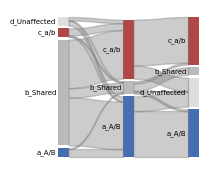

In [30]:
df = observed[['observed_group', 'true_group', 'model_group']]
df = df[df.true_group != 'd_Unaffected']
df = df.sort_values(['true_group', 'model_group', 'observed_group'],)
colorDict = {'d_Unaffected':'#dbdbdb', 
            'a_A/B':'#325ea8', 
            'c_a/b':'#a83232',
            'b_Shared':'#b3b3b3'}
sky = Sankey(df[['observed_group', 'true_group', 'model_group']],colorMode="global",colorDict = colorDict)
fig,ax = sky.plot(figSize = (2,2), fontSize = 5, )
fig.savefig('../figures/S3D.pdf')

In [31]:
linewidth = 0.5

In [32]:
palette = ["#9c9998", "#992702"]

In [ ]:
fig, ax = plt.subplots(4,4, figsize = (7.5,8))

X_plot = np.linspace(-2.5, 2.5)
Y_plot = X_plot
for axs in np.ravel(ax):
    sns.lineplot(x=X_plot, y=Y_plot, color = 'k', linestyle='--', linewidth=1, ax = axs, alpha = 0.5)
    axs.axhline(0.0, color='k', linestyle='--', linewidth=1, alpha = 0.5) 
    axs.axvline(0.0, color='k', linestyle='--', linewidth=1, alpha = 0.5) 

sns.scatterplot(observed.iloc[ab_not_AB], x = 'Eff_up', y = 'A_l', ax = ax[0, 0], s = 5, hue = observed.iloc[ab_not_AB].A_p < 0.05, palette=palette, legend = False, linewidth = linewidth)
sns.scatterplot(observed.iloc[AB_not_ab], x = 'Eff_up', y = 'A_l', ax = ax[0, 1], s = 5, hue = observed.iloc[AB_not_ab].A_p < 0.05, palette=palette, legend = False, linewidth = linewidth)
sns.scatterplot(observed.iloc[both], x = 'Eff_up', y = 'A_l', ax = ax[0, 2], s = 5, hue = observed.iloc[both].A_p < 0.05, palette=palette, legend = False, linewidth = linewidth)
sns.scatterplot(observed.iloc[none], x = 'Eff_up', y = 'A_l', ax = ax[0, 3], s = 5, hue = observed.iloc[none].A_p < 0.05, palette=palette, legend = False, linewidth = linewidth)

for i in range(4):
    ax[0, i].set_xlabel('Added effect size [log2(A/B)]')
    ax[0, i].set_ylabel('Observed effect size [log2(A/B)]')
    ax[0, i].set_xlim(-2.5, 2.5)
    ax[0, i].set_ylim(-2.5, 2.5)
ax[0, 0].set_title('a/b exclusive ' + f'[n={sum(ab_not_AB)}]')
ax[0, 0].text(x = -2, y = 2, s = f'p<0.05 [n={sum(observed.iloc[ab_not_AB].A_p < 0.05)}]')
ax[0, 1].set_title('A/B exclusive '+ f'[n={sum(AB_not_ab)}]')
ax[0, 1].text(x = -2, y = 2, s = f'p<0.05 [n={sum(observed.iloc[AB_not_ab].A_p < 0.05)}]')
ax[0, 2].set_title('Shared '+ f'[n={sum(both)}]')
ax[0, 2].text(x = -2, y = 2, s = f'p<0.05 [n={sum(observed.iloc[both].A_p < 0.05)}]')
ax[0, 3].set_title('Unaffected '+ f'[n={sum(none)}]')
ax[0, 3].text(x = -2, y = 2, s = f'p<0.05 [n={sum(observed.iloc[none].A_p < 0.05)}]')

sns.scatterplot(observed.iloc[ab_not_AB], x = 'Eff_up', y = 'Difference', ax = ax[1, 0], s = 5, hue = observed.iloc[ab_not_AB].Pvalue < 0.05, palette=palette, legend = False, linewidth = linewidth)
sns.scatterplot(observed.iloc[AB_not_ab], x = 'Eff_up', y = 'Difference', ax = ax[1, 1], s = 5, hue = observed.iloc[AB_not_ab].Pvalue < 0.05, palette=palette, legend = False, linewidth = linewidth)
sns.scatterplot(observed.iloc[both], x = 'Eff_up', y = 'Difference', ax = ax[1, 2], s = 5, hue= observed.iloc[both].Pvalue < 0.05, palette=palette, legend = False, linewidth = linewidth)
sns.scatterplot(observed.iloc[none], x = 'Eff_up', y = 'Difference', ax = ax[1, 3], s = 5, hue = observed.iloc[none].Pvalue < 0.05, palette=palette, legend = False, linewidth = linewidth)

for i in range(4):
    ax[1, i].set_xlabel('Added effect size [log2(A/B)]')
    ax[1, i].set_ylabel('DeepDIVE effect size [log2(A/B)]')
    ax[1, i].set_xlim(-2.5, 2.5)
    ax[1, i].set_ylim(-2.5, 2.5)
ax[1, 0].set_title('a/b exclusive ' + f'[n={sum(ab_not_AB)}]')
ax[1, 0].text(x = -2, y = 2, s = f'p<0.05 [n={sum(observed.iloc[ab_not_AB].Pvalue < 0.05)}]')
ax[1, 1].set_title('A/B exclusive '+ f'[n={sum(AB_not_ab)}]')
ax[1, 1].text(x = -2, y = 2, s = f'p<0.05 [n={sum(observed.iloc[AB_not_ab].Pvalue < 0.05)}]')
ax[1, 2].set_title('Shared '+ f'[n={sum(both)}]')
ax[1, 2].text(x = -2, y = 2, s = f'p<0.05 [n={sum(observed.iloc[both].Pvalue < 0.05)}]')
ax[1, 3].set_title('Unaffected '+ f'[n={sum(none)}]')
ax[1, 3].text(x = -2, y = 2, s = f'p<0.05 [n={sum(observed.iloc[none].Pvalue < 0.05)}]')

sns.scatterplot(observed.iloc[ab_not_AB], x = 'Eff_low', y = 'A_l', ax = ax[2, 0], s = 5, hue = observed.iloc[ab_not_AB].A_p < 0.05, palette=palette, legend = False, linewidth = linewidth)
sns.scatterplot(observed.iloc[AB_not_ab], x = 'Eff_low', y = 'A_l', ax = ax[2, 1], s = 5, hue = observed.iloc[AB_not_ab].A_p < 0.05, palette=palette, legend = False, linewidth = linewidth)
sns.scatterplot(observed.iloc[both], x = 'Eff_low', y = 'A_l', ax = ax[2, 2], s = 5, hue = observed.iloc[both].A_p < 0.05, palette=palette, legend = False, linewidth = linewidth)
sns.scatterplot(observed.iloc[none], x = 'Eff_low', y = 'A_l', ax = ax[2, 3], s = 5, hue = observed.iloc[none].A_p < 0.05, palette=palette, legend = False, linewidth = linewidth)

for i in range(4):
    ax[2, i].set_xlabel('Added effect size [log2(a/b)]')
    ax[2, i].set_ylabel('Observed effect size [log2(A/B)]')
    ax[2, i].set_xlim(-2.5, 2.5)
    ax[2, i].set_ylim(-2.5, 2.5)
ax[2, 0].set_title('a/b exclusive ' + f'[n={sum(ab_not_AB)}]')
ax[2, 0].text(x = -2, y = 2, s = f'p<0.05 [n={sum(observed.iloc[ab_not_AB].A_p < 0.05)}]')
ax[2, 1].set_title('A/B exclusive '+ f'[n={sum(AB_not_ab)}]')
ax[2, 1].text(x = -2, y = 2, s = f'p<0.05 [n={sum(observed.iloc[AB_not_ab].A_p < 0.05)}]')
ax[2, 2].set_title('Shared '+ f'[n={sum(both)}]')
ax[2, 2].text(x = -2, y = 2, s = f'p<0.05 [n={sum(observed.iloc[both].A_p < 0.05)}]')
ax[2, 3].set_title('Unaffected '+ f'[n={sum(none)}]')
ax[2, 3].text(x = -2, y = 2, s = f'p<0.05 [n={sum(observed.iloc[none].A_p < 0.05)}]')

sns.scatterplot(observed.iloc[ab_not_AB], x = 'Eff_low', y = 'Difference', ax = ax[3, 0], s = 5, hue = observed.iloc[ab_not_AB].Pvalue < 0.05, palette=palette, legend = False, linewidth = linewidth)
sns.scatterplot(observed.iloc[AB_not_ab], x = 'Eff_low', y = 'Difference', ax = ax[3, 1], s = 5, hue = observed.iloc[AB_not_ab].Pvalue < 0.05, palette=palette, legend = False, linewidth = linewidth)
sns.scatterplot(observed.iloc[both], x = 'Eff_low', y = 'Difference', ax = ax[3, 2], s = 5, hue = observed.iloc[both].Pvalue < 0.05, palette=palette, legend = False, linewidth = linewidth)
sns.scatterplot(observed.iloc[none], x = 'Eff_low', y = 'Difference', ax = ax[3, 3], s = 5, hue = observed.iloc[none].Pvalue < 0.05, palette=palette, legend = False, linewidth = linewidth)

for i in range(4):
    ax[3, i].set_xlabel('Added effect size [log2(a/b)]')
    ax[3, i].set_ylabel('DeepDIVE effect size [log2(A/B)]')
    ax[3, i].set_xlim(-2.5, 2.5)
    ax[3, i].set_ylim(-2.5, 2.5)
ax[3, 0].set_title('a/b exclusive ' + f'[n={sum(ab_not_AB)}]')
ax[3, 0].text(x = -2, y = 2, s = f'p<0.05 [n={sum(observed.iloc[ab_not_AB].Pvalue < 0.05)}]')
ax[3, 1].set_title('A/B exclusive '+ f'[n={sum(AB_not_ab)}]')
ax[3, 1].text(x = -2, y = 2, s = f'p<0.05 [n={sum(observed.iloc[AB_not_ab].Pvalue < 0.05)}]')
ax[3, 2].set_title('Shared '+ f'[n={sum(both)}]')
ax[3, 2].text(x = -2, y = 2, s = f'p<0.05 [n={sum(observed.iloc[both].Pvalue < 0.05)}]')
ax[3, 3].set_title('Unaffected '+ f'[n={sum(none)}]')
ax[3, 3].text(x = -2, y = 2, s = f'p<0.05 [n={sum(observed.iloc[none].Pvalue < 0.05)}]')

plt.tight_layout()
fig.savefig('../figures/S3E.pdf', transparent=True)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

In [ ]:
target_precision = 0.95

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

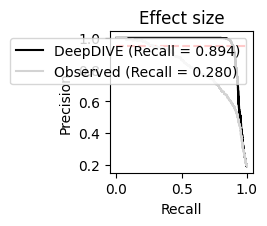

In [35]:
plt.subplots(1,1, figsize = (1.85,1.835))
plt.hlines(y = target_precision, xmin = 0, xmax = 1, linestyle = '--', color = 'r')
average_precision = average_precision_score(abs(observed.Eff_up) > 0, abs(observed.Difference))
precision, recall, thresholds = precision_recall_curve(abs(observed.Eff_up) > 0, abs(observed.Difference))
recall_at_thresh = find_recall(precision, recall, target_precision)
sns.lineplot(x = recall, y = precision, label = f"DeepDIVE (Recall = {recall_at_thresh:.3f})", color = 'k', estimator=None)
average_precision = average_precision_score(abs(observed.Eff_up) > 0, abs(observed.A_l))
precision, recall, thresholds = precision_recall_curve(abs(observed.Eff_up) > 0, abs(observed.A_l))
recall_at_thresh = find_recall(precision, recall, target_precision)
sns.lineplot(x = recall, y = precision, label = f"Observed (Recall = {recall_at_thresh:.3f})", color = 'lightgrey', estimator=None)
     
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Effect size')
plt.savefig('../figures/F1D.pdf', transparent=True)

## DeepDive performance over range of colinearity strengths

In [36]:
n_decoders = 20  
model_params = {
    'n_epochs_pretrain_ae' : 200*n_decoders,
    'n_decoders' : n_decoders,
}
train_params = {
    'max_epoch' : 300*n_decoders, 
    'batch_size' : 512, 
}
discrete_covriate_keys = ['Uppercase', 'Lowercase']

In [37]:
files = glob.glob(f'output_*.tsv', root_dir = '../data/Simulated')

In [38]:
entanglement = []
indexes = []
average_precision_dd = []
average_precision_lfc = []

average_precision_dd_p = []
average_precision_lfc_p = []

auroc_dd = []
auroc_lfc = []
auroc_dd_p = []
auroc_lfc_p = []

runs = []

for f in files:
    print(f)
    _, run, idx, i = f.split('.tsv')[0].split('_')

    
    i = float(i)
    idx = int(idx)
    run = int(run)
    runs.append(run)
    indexes.append(idx)
    entanglement.append(i)
    observed = pd.read_csv('../data/Simulated'+'/'+f, sep = '\t', index_col = 0)
    
    average_precision_dd.append(average_precision_score(abs(observed.Eff_up) > 0, abs(observed.Difference)))
    average_precision_lfc.append(average_precision_score(abs(observed.Eff_up) > 0, abs(observed.A_l)))
    average_precision_dd_p.append(average_precision_score(abs(observed.Eff_up) > 0, -np.log10(observed.Pvalue + 1e-8)))
    average_precision_lfc_p.append(average_precision_score(abs(observed.Eff_up) > 0, -np.log10(observed.A_p + 1e-8)))
    
    auroc_dd.append(roc_auc_score(abs(observed.Eff_up) > 0, abs(observed.Difference)))
    auroc_lfc.append(roc_auc_score(abs(observed.Eff_up) > 0, abs(observed.A_l)))
    
    auroc_dd_p.append(roc_auc_score(abs(observed.Eff_up) > 0, -np.log10(observed.Pvalue + 1e-8)))
    auroc_lfc_p.append(roc_auc_score(abs(observed.Eff_up > 0), -np.log10(observed.A_p + 1e-8)))


output_1_0_0.0.tsv
output_0_7_0.7000000000000001.tsv
output_2_10_1.0.tsv
output_0_0_0.0.tsv
output_0_6_0.6000000000000001.tsv
output_2_4_0.4.tsv
output_1_10_1.0.tsv
output_1_9_0.9.tsv
output_1_6_0.6000000000000001.tsv
output_2_7_0.7000000000000001.tsv
output_1_8_0.8.tsv
output_2_1_0.1.tsv
output_2_9_0.9.tsv
output_1_5_0.5.tsv
output_0_1_0.1.tsv
output_2_5_0.5.tsv
output_2_2_0.2.tsv
output_1_3_0.30000000000000004.tsv
output_0_4_0.4.tsv
output_0_2_0.2.tsv
output_1_1_0.1.tsv
output_2_3_0.30000000000000004.tsv
output_2_6_0.6000000000000001.tsv
output_0_8_0.8.tsv
output_1_2_0.2.tsv
output_0_9_0.9.tsv
output_0_5_0.5.tsv
output_1_4_0.4.tsv
output_0_10_1.0.tsv
output_2_8_0.8.tsv
output_1_7_0.7000000000000001.tsv
output_2_0_0.0.tsv
output_0_3_0.30000000000000004.tsv


In [39]:
result = pd.concat([pd.Series(x) for x in [indexes, entanglement, runs, 
                                           average_precision_lfc_p, average_precision_dd_p]],axis = 1)
result.columns = ['idx', 'i', 'run', 'lfc_p', 'dd_p']
result = result.sort_values('idx')

In [40]:
colors = get_colormap_colors('RdBu', 11)

In [41]:
mean = result.groupby('idx').mean()
sd = result.groupby('idx').std()

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

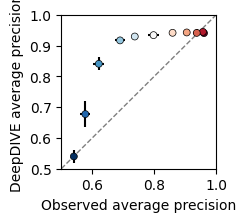

In [42]:
fig, ax = plt.subplots(1,1, figsize = (2,2))
X_plot = np.linspace(0.5, 1)
Y_plot = X_plot
sns.lineplot(x=X_plot, y=Y_plot, color = 'k', linestyle='--', linewidth=1, ax = ax, alpha = 0.5)
sns.scatterplot(mean, x = 'lfc_p', y = 'dd_p', c = [colors[i] for i in mean.index], s = 25, ax = ax, linewidth = 0.5, edgecolor = 'k')
plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")
plt.errorbar(mean.lfc_p, mean.dd_p, xerr=sd.lfc_p, yerr=sd.dd_p, fmt="none", color="k")

plt.xlim(0.5, 1)
plt.ylim(0.5, 1)
plt.xlabel('Observed average precision')
plt.ylabel('DeepDIVE average precision')
plt.savefig('../figures/F1E.pdf', transparent=True)

## Quantify in expression bins

In [43]:
entanglement = []
indexes = []
bin_ap_dd = []
bin_ap_lfc = []
bin_n = []
runs = []

for f in files:
    print(f)
    _, run, idx, i = f.split('.tsv')[0].split('_')
    adata_sim = sc.read_h5ad(f'../data/Simulated/simulated_{run}_{idx}_{i}.h5ad')
    i = float(i)
    idx = int(idx)
    run = int(run)
    observed = pd.read_csv('../data/Simulated'+'/'+f, sep = '\t', index_col = 0)
    sc.read(f'../data/Simulated/simulated_{run}_{idx}_{i}.h5ad')
    
    nbins = 3
    observed['expression_'] = np.array(adata_sim.X.sum(axis = 0)).flatten()
    bins = pd.qcut(observed.expression_.abs(), q=nbins, labels=False)
    observed['expression_bin'] = bins
    
    for b in range(0, nbins):
        tmp = observed[observed.expression_bin == b]
        bin_n.append(b)
        bin_ap_dd.append(average_precision_score(abs(tmp.Eff_up) > 0, abs(tmp.Difference)))
        bin_ap_lfc.append(average_precision_score(abs(tmp.Eff_up) > 0, abs(tmp.A_l)))
    
        
        i = float(i)
        idx = int(idx)
        run = int(run)
        runs.append(run)
        indexes.append(idx)
        entanglement.append(i)


output_1_0_0.0.tsv
output_0_7_0.7000000000000001.tsv
output_2_10_1.0.tsv
output_0_0_0.0.tsv
output_0_6_0.6000000000000001.tsv
output_2_4_0.4.tsv
output_1_10_1.0.tsv
output_1_9_0.9.tsv
output_1_6_0.6000000000000001.tsv
output_2_7_0.7000000000000001.tsv
output_1_8_0.8.tsv
output_2_1_0.1.tsv
output_2_9_0.9.tsv
output_1_5_0.5.tsv
output_0_1_0.1.tsv
output_2_5_0.5.tsv
output_2_2_0.2.tsv
output_1_3_0.30000000000000004.tsv
output_0_4_0.4.tsv
output_0_2_0.2.tsv
output_1_1_0.1.tsv
output_2_3_0.30000000000000004.tsv
output_2_6_0.6000000000000001.tsv
output_0_8_0.8.tsv
output_1_2_0.2.tsv
output_0_9_0.9.tsv
output_0_5_0.5.tsv
output_1_4_0.4.tsv
output_0_10_1.0.tsv
output_2_8_0.8.tsv
output_1_7_0.7000000000000001.tsv
output_2_0_0.0.tsv
output_0_3_0.30000000000000004.tsv


In [44]:
result = pd.concat([pd.Series(x) for x in [indexes, entanglement, runs, bin_ap_lfc, bin_ap_dd, bin_n]],axis = 1)
result.columns = ['idx', 'i', 'run', 'lfc', 'dd', 'bin']
result = result.sort_values('idx')
mean = result.groupby(['idx', 'bin']).mean()
sd = result.groupby(['idx', 'bin']).std()

In [45]:
colors1 = get_colormap_colors('Reds', 11)
colors2 = get_colormap_colors('Blues', 11)
colors3 = get_colormap_colors('Greens', 11)
colors_neg = get_colormap_colors('Purples', 11)
colors = [colors_neg, colors1, colors2, colors3]

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

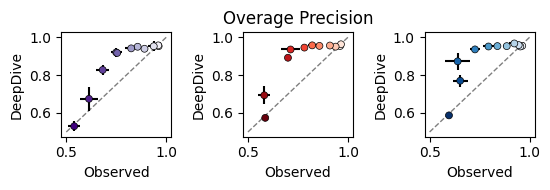

In [46]:
fig, ax = plt.subplots(1,3, figsize = (2*2.8,2))
for b in [0, 1,2]:
    
    X_plot = np.linspace(0.5, 1)
    Y_plot = X_plot
    sns.lineplot(x=X_plot, y=Y_plot, color = 'k', linestyle='--', linewidth=1, ax = ax[b], alpha = 0.5)
    
    mean_tmp = mean.reset_index()[mean.reset_index()['bin'] == b].set_index(['idx', 'bin'])
    sd_tmp = sd.reset_index()[sd.reset_index()['bin'] == b].set_index(['idx', 'bin'])
    
    sns.scatterplot(mean_tmp, x = 'lfc', y = 'dd', c = [colors[b][i] for i in [x for x,y in mean_tmp.index]], s = 25, ax = ax[b], linewidth = 0.5, edgecolor = 'k')
    plt.setp(ax[b].lines, zorder=100)
    plt.setp(ax[b].collections, zorder=100, label="")
    ax[b].errorbar(mean_tmp.lfc, mean_tmp.dd, xerr=sd_tmp.lfc, yerr=sd_tmp.dd, fmt="none", color="k")

ax[0].set_xlabel('Observed')
ax[1].set_xlabel('Observed')
ax[2].set_xlabel('Observed')

ax[0].set_ylabel('DeepDive')
ax[1].set_ylabel('DeepDive')
ax[2].set_ylabel('DeepDive')
ax[1].set_title('Overage Precision')
plt.tight_layout()
plt.savefig('../figures/S4D.pdf', transparent=True)

## DeepDive disentanglement of continuous covariates

In [47]:
n_decoders = 10 
model_params = {
    'n_epochs_pretrain_ae' : 200*n_decoders,
    'n_decoders' : n_decoders,
 
}
train_params = {
    'max_epoch' : 300*n_decoders, 
    'batch_size' : 512, 
}

In [48]:
files = glob.glob(f'output_*.tsv', root_dir = '../data/Simulated_continuous')

In [49]:
entanglement = []
indexes = []
average_precision_dd_p = []
average_precision_lfc_p = []
s_corr = []
runs = []

for f in files:
    print(f)
    _, run, idx, i = f.split('.tsv')[0].split('_')

    
    i = float(i)
    idx = int(idx)
    run = int(run)
    runs.append(run)
    indexes.append(idx)
    entanglement.append(i)
    observed = pd.read_csv('../data/Simulated_continuous'+'/'+f, sep = '\t', index_col = 0)
    
    average_precision_dd_p.append(average_precision_score(abs(observed.Eff_cov2) > 0, -np.log10(observed.Pvalue_cov2 + 1e-8)))
    average_precision_lfc_p.append(average_precision_score(abs(observed.Eff_cov2) > 0, -np.log10(observed.high2_p + 1e-8)))
    
    tmp = sc.read_h5ad(f'../data/Simulated_continuous/simulated_{run}_{idx}_{i}.h5ad').obs
    c = spearmanr(tmp.cov2, tmp.cov3).correlation
    s_corr.append(c)


output_1_6_0.6000000000000001.tsv
output_0_5_0.5.tsv
output_1_5_0.5.tsv
output_0_9_0.9.tsv
output_1_0_0.0.tsv
output_2_4_0.4.tsv
output_2_3_0.30000000000000004.tsv
output_0_4_0.4.tsv
output_2_1_0.1.tsv
output_0_3_0.30000000000000004.tsv
output_0_7_0.7000000000000001.tsv
output_1_2_0.2.tsv
output_2_8_0.8.tsv
output_2_7_0.7000000000000001.tsv
output_2_0_0.0.tsv
output_0_2_0.2.tsv
output_2_10_1.0.tsv
output_0_10_1.0.tsv
output_1_9_0.9.tsv
output_1_10_1.0.tsv
output_1_1_0.1.tsv
output_2_9_0.9.tsv
output_1_7_0.7000000000000001.tsv
output_1_4_0.4.tsv
output_0_0_0.0.tsv
output_1_8_0.8.tsv
output_2_6_0.6000000000000001.tsv
output_1_3_0.30000000000000004.tsv
output_0_8_0.8.tsv
output_0_6_0.6000000000000001.tsv
output_2_2_0.2.tsv
output_2_5_0.5.tsv
output_0_1_0.1.tsv


In [50]:
result = pd.concat([pd.Series(x) for x in [indexes,s_corr, entanglement, runs, average_precision_lfc_p, average_precision_dd_p]],axis = 1)
result.columns = ['idx', 'corr', 'i', 'run', 'lfc_p', 'dd_p']
result = result.sort_values('idx')

In [51]:
bins = np.arange(-1+0.00001,  1+0.20001, 0.2) 
bin_indices = np.digitize(result['corr'], bins) - 1 

bin_labels = [(bins[i], bins[i+1]) for i in range(len(bins)-1)]
binned_labels = [bin_labels[i] if 0 <= i < len(bin_labels) else None for i in bin_indices]

In [52]:
result['corr_bin'] = binned_labels
bin_mapping = {y:x for x, y in enumerate(bin_labels)}
bin_idx_to_corr_mapping = {x:y for x, y in enumerate(bin_labels)}
result['corr_bin_idx'] = result['corr_bin'].map(bin_mapping)

In [53]:
mean = result.groupby('corr_bin_idx').mean()
sd = result.groupby('corr_bin_idx').std()

In [54]:
colors = get_colormap_colors('RdBu', len(bins))

In [55]:
sd = sd.dropna()
mean = mean.loc[sd.index]

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

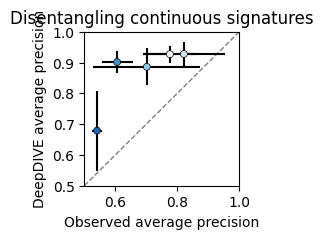

In [56]:
fig, ax = plt.subplots(1,1, figsize = (2,2))

X_plot = np.linspace(0.5, 1)
Y_plot = X_plot
sns.lineplot(x=X_plot, y=Y_plot, color = 'k', linestyle='--', linewidth=1, ax = ax, alpha = 0.5)
    
sns.scatterplot(mean, x = 'lfc_p', y = 'dd_p', c = [colors[i] for i in mean.index], s = 25, ax = ax, linewidth = 0.5, edgecolor = 'k')
plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")
plt.errorbar(mean.lfc_p, mean.dd_p, xerr=sd.lfc_p, yerr=sd.dd_p, fmt="none", color="k")

plt.xlim(0.5, 1)
plt.ylim(0.5, 1)
plt.xlabel('Observed average precision')
plt.ylabel('DeepDIVE average precision')
plt.title('Disentangling continuous signatures')
plt.savefig('../figures/S4A.pdf', transparent=True)

## Performance with missing labels

out_res = []
runs = []
effectsize = []
n_cells = 10_000
n_features = 5000
steps = [0.2, 0.4, 0.6]
cramers = np.arange(0.0, 1.05, 0.2)
n_runs = 3
n_groups = 20


for run in range(n_runs):
    for idx, i in enumerate(steps): 
        for cdx, c in enumerate(cramers):
        
            a = generate_dependency_matrix(2, 2, c)
            b = np.repeat(a[np.newaxis, :, :], n_groups, axis=0)
            dependency = b/b.sum()

            discrete_covariates = {'cov1': [f'g{x+1}' for x in range(n_groups)], 
                                   'Uppercase': ['A', 'B'], 
                                   'Lowercase': ['a', 'b']}
            discrete_covriate_keys = list(discrete_covariates.keys())

            simulation_result = simulate_scATAC_seq_data_missing(
                n_cells, 
                n_features, 
                discrete_covariates=discrete_covariates,
                max_effect_sizes=[0.5, 0.7, 0.7],
                sample_feature_p=[0.05, 0.1, 0.1],
                dependency=dependency, 
                continuous_entanglement = 0

            )

            fragment_counts = simulation_result["data"]
            covariate_assignments = simulation_result["covariate_assignments"]
            pivot = simulation_result["pivot"]
            effect_sizes = simulation_result["effect_sizes"]

            adata = anndata.AnnData(fragment_counts)
            adata.X = sparse.csr_matrix(adata.X) 
            adata.obs = covariate_assignments
            adata.obs[discrete_covriate_keys] = adata.obs[discrete_covriate_keys].astype(str)

            true_before = adata.obs['Uppercase'].copy()

            to_mask = np.random.choice(covariate_assignments.cov1.unique(), size = int(20 * i), replace = False)
            adata.obs.loc[adata.obs.cov1.isin(to_mask), 'Uppercase'] = 'Masked'

            adata.write_h5ad(f'../data/Masked/simulated_{run}_{idx}_{i}_{c}.h5ad')

            import pickle 

            with open(f'../data/Masked/effectsize_{run}_{idx}_{i}_{c}.pkl', 'wb') as f:
                pickle.dump(effect_sizes, f)

            with open(f'../data/Masked/pivot_{run}_{idx}_{i}_{c}.pkl', 'wb') as f:
                pickle.dump(pivot, f)

            model = DeepDive.DeepDive(adata = adata, 
                                discrete_covariate_names = discrete_covriate_keys,
                                      unknown_keys = {'Uppercase':'Masked'},
                                **model_params
                               )

            model.train_model(adata, None, 
                          **train_params)

            model_path = f'../data/Masked/DeepDIVE_{run}_{idx}_{i}_{c}.pt'
            torch.save(model.state_dict(), model_path)
            model.load_state_dict(torch.load(model_path))

            observed = get_DE(adata, effect_sizes)

            DE, DE_low = get_model_DE(model, adata)

            observed['Difference'] = DE['Difference'].values
            observed['Zscore'] = DE['Zscore'].values
            observed['FDR'] = DE['FDR'].values
            observed['Pvalue'] = DE['Pvalue'].values
            observed['Difference_low'] = DE_low['Difference'].values
            observed['Zscore_low'] = DE_low['Zscore'].values
            observed['FDR_low'] = DE_low['FDR'].values
            observed['Pvalue_low'] = DE_low['Pvalue'].values

            observed.to_csv(f'../data/Masked/output_{run}_{idx}_{i}_{c}.tsv', sep = '\t')


In [57]:
files = glob.glob(f'output_*.tsv', root_dir = '../data/Masked')

In [58]:
entanglement = []
indexes = []
average_precision_dd = []
average_precision_lfc = []

average_precision_dd_p = []
average_precision_lfc_p = []

auroc_dd = []
auroc_lfc = []
auroc_dd_p = []
auroc_lfc_p = []
cramers = []

runs = []

for f in files:
    print(f)
    _, run, idx, i, c = f.split('.tsv')[0].split('_')
    
    i = float(i)
    idx = int(idx)
    run = int(run)
    runs.append(run)
    indexes.append(idx)
    entanglement.append(i)
    cramers.append(c)
    observed = pd.read_csv('../data/Masked'+'/'+f, sep = '\t', index_col = 0)
    
    average_precision_dd_p.append(average_precision_score(abs(observed.Eff_up) > 0, -np.log10(observed.Pvalue + 1e-8)))
    average_precision_lfc_p.append(average_precision_score(abs(observed.Eff_up) > 0, -np.log10(observed.A_p + 1e-8)))


output_1_1_0.6_0.6000000000000001.tsv
output_1_2_0.8_0.2.tsv
output_2_0_0.4_0.4.tsv
output_2_1_0.6_0.2.tsv
output_0_0_0.4_0.4.tsv
output_2_2_0.8_1.0.tsv
output_0_1_0.5_0.0.tsv
output_0_0_0.4_0.0.tsv
output_0_1_0.6_0.4.tsv
output_1_0_0.2_0.4.tsv
output_2_2_0.8_0.0.tsv
output_1_2_0.8_1.0.tsv
output_2_0_0.2_1.0.tsv
output_2_0_0.4_0.8.tsv
output_2_1_0.5_1.0.tsv
output_2_1_0.6_0.0.tsv
output_1_0_0.2_0.0.tsv
output_2_0_0.2_0.8.tsv
output_2_2_0.8_0.4.tsv
output_1_1_0.5_1.0.tsv
output_2_1_0.6_0.6000000000000001.tsv
output_1_2_0.8_0.6000000000000001.tsv
output_0_1_0.5_0.4.tsv
output_2_2_0.8_0.8.tsv
output_2_0_0.2_0.0.tsv
output_0_0_0.4_0.6000000000000001.tsv
output_0_0_0.2_0.2.tsv
output_2_1_0.6_0.8.tsv
output_0_0_0.2_0.0.tsv
output_1_2_0.8_0.0.tsv
output_1_0_0.2_0.2.tsv
output_1_1_0.6_1.0.tsv
output_2_2_0.8_0.2.tsv
output_0_2_0.8_0.0.tsv
output_1_2_0.8_0.8.tsv
output_0_0_0.2_0.6000000000000001.tsv
output_0_1_0.5_1.0.tsv
output_2_1_0.6_1.0.tsv
output_2_0_0.4_0.0.tsv
output_2_1_0.6_0.4.tsv
outpu

In [59]:
result = pd.concat([pd.Series(x) for x in [indexes, entanglement, runs, cramers,average_precision_lfc_p, average_precision_dd_p]],axis = 1)
result.columns = ['idx', 'i', 'run','cramers', 'lfc_p', 'dd_p']
result = result.sort_values('idx')

In [60]:
result = result[result.i.isin([0.2, 0.4, 0.6])].sort_values(['i', 'cramers', 'run'])

In [61]:
means = result.groupby(['i', 'cramers']).mean().reset_index()
sds = result.groupby(['i', 'cramers']).std().reset_index()

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

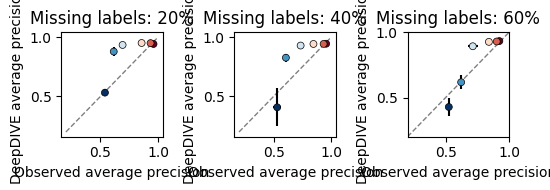

In [62]:
fig, ax = plt.subplots(1,3, figsize = (1.8*3,2))

percents = [0.2, 0.4, 0.6]
for percent, frac in enumerate(percents):
    mean = means[means.i == frac].set_index('cramers')
    sd = sds[sds.i == frac].set_index('cramers')

    X_plot = np.linspace(0.2, 1)
    Y_plot = X_plot
    sns.lineplot(x=X_plot, y=Y_plot, color = 'k', linestyle='--', linewidth=1, ax = ax[percent], alpha = 0.5)

    sns.scatterplot(mean, x = 'lfc_p', y = 'dd_p', c = [colors[int(c*10)] for c in mean.index.map(float)], s = 25, ax = ax[percent], linewidth = 0.5, edgecolor = 'k')
    plt.setp(ax[percent].lines, zorder=100)
    plt.setp(ax[percent].collections, zorder=100, label="")
    ax[percent].errorbar(mean.lfc_p, mean.dd_p, xerr=sd.lfc_p, yerr=sd.dd_p, fmt="none", color="k")

    plt.xlim(0.2, 1)
    plt.ylim(0.2, 1)
    ax[percent].set_xlabel('Observed average precision')
    ax[percent].set_ylabel('DeepDIVE average precision')


    ax[percent].set_title(f'Missing labels: {int(frac*100)}%')#
plt.tight_layout()
plt.savefig('../figures/S4E.pdf', transparent=True)